<a href="https://colab.research.google.com/github/RobBurnap/Bioinformatics-MICR4203-MICR5203/blob/main/notebooks/PAM_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# PAM Matrices in Practice: from PAM1 to PAM_n and an estimated rate matrix \(Q\)

This notebook lets you:
1. Load a **Dayhoff PAM1** mutation probability matrix (the 20×20 table; rows sum to 1).
2. Convert from the common **×10,000 scaled table** to probabilities.
3. Compute **PAMⁿ** by repeated multiplication and visualize the result.
4. (Optional) Estimate an instantaneous **rate matrix** \(Q \approx \log(\text{PAM1})\) and reconstruct **PAMⁿ** via `expm(Q*n)`.
5. Inspect matrices as tables and heatmaps, and see the **diagonal decay** (probability of no change) vs. \(n\).

> Teaching note: The higher powers of PAM1 capture **multiple hits** implicitly; the matrix power \( (\text{PAM1})^n \) is equivalent to \( e^{Qn} \) if \(\text{PAM1} = e^{Q}\).


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import expm, logm
from IPython.display import display

aas = ["A","R","N","D","C","Q","E","G","H","I",
       "L","K","M","F","P","S","T","W","Y","V"]

def show_df(M, title=None, round_to=6):
    if round_to is not None:
        M = np.round(M, round_to)
    df = pd.DataFrame(M, index=aas, columns=aas)
    if title:
        print(title)
    display(df)

def heatmap(M, title):
    plt.figure(figsize=(6,5))
    plt.imshow(M, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    plt.xticks(range(20), aas, rotation=90)
    plt.yticks(range(20), aas)
    plt.tight_layout()
    plt.show()

def pam_power(P1: np.ndarray, n: int) -> np.ndarray:
    return np.linalg.matrix_power(P1, n)



## Load PAM1 (Dayhoff) — scaled by 10,000 and convert to probabilities


In [ ]:

pam1_scaled = np.array([
 [9867,   1,   4,   6,   1,   3,  10,  21,   1,   2,   3,   2,   1,   1,  13,  28,  22,   0,   1,  13],
 [   2,9913,   1,   0,   1,   9,   0,   1,   8,   2,   1,  37,   1,   1,   5,  11,   2,   0,   0,   2],
 [   9,   1,9822,  42,   0,   4,   7,  12,  18,   3,   2,  25,   0,   1,   2,  34,  13,   0,   3,   2],
 [  10,   0,  36,9859,   0,   5,  56,  11,   3,   1,   0,   6,   0,   0,   0,   1,   7,   4,   0,   0],
 [   3,   1,   0,   0,9973,   0,   0,   1,   1,   2,   0,   0,   0,   0,   1,  11,   1,   0,   0,   3],
 [   8,  10,   4,   6,   0,9876,  35,   3,  20,   1,   6,  12,   2,   2,   8,   4,   3,   0,   0,   2],
 [  17,   0,   6,  53,   0,  27,9865,   7,   1,   2,   1,   1,   0,   0,   3,   6,   2,   0,   0,   2],
 [  21,   0,   6,   6,   0,   1,   4,9935,   0,   1,   2,   0,   1,   0,   2,  16,   2,   0,   0,   3],
 [   2,  10,  21,   4,   1,  23,   2,   0,9912,   0,   4,   2,   0,   0,   2,   5,   1,   0,   4,   3],
 [   6,   3,   3,   1,   1,   4,   1,   0,   0,9872,  22,   4,   5,   8,   1,   2,  11,   0,   1,  57],
 [   4,   1,   1,   0,   0,   3,   1,   1,   0,   2,9947,   1,   8,   6,   2,   1,   2,   0,   1,  11],
 [   2,  19,  13,   3,   0,   6,   4,   2,   1,   2,   3,9926,   4,   4,   2,   7,   8,   0,   0,   1],
 [   6,   4,   0,   0,   0,   4,   1,   0,  12,  45,  20,   0,9874,   4,   1,   4,   6,   0,   0,  17],
 [   2,   1,   1,   0,   0,   0,   1,   2,   7,  13,   0,   0,   0,9946,   1,   3,   1,   1,  21,   3],
 [  22,   4,   2,   1,   1,   6,   3,   3,   0,   3,   3,   0,   0,   0,9926,  17,   5,   0,   0,   2],
 [  35,   6,  20,   5,   0,   2,   4,  21,   1,   3,   0,   1,   1,   2,  12,9840,  32,   1,   1,   1],
 [  32,   1,   9,   3,   1,   2,   3,   0,   7,   3,   1,   0,   2,   1,   4,  38,9871,   0,   1,   2],
 [   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5,   0,9976,   2,   0],
 [   2,   0,   4,   0,   0,   3,   0,   1,   4,   0,   1,   0,   0,   0,   0,   2,   0,   1,9945,   2],
 [  18,   1,   1,   1,   2,   1,   2,   5,   1,  33,  15,   1,   4,   0,   2,   2,   9,   0,   1,9901]
], dtype=float)

PAM1 = pam1_scaled / 10000.0
row_sums = PAM1.sum(axis=1)
show_df(PAM1, "PAM1 probabilities (rows should sum to ~1)", round_to=6)
print("Row sums:", np.round(row_sums, 6))


PAM1 probabilities (rows should sum to ~1)


,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V
A,0.9867,0.0001,0.0004,0.0006,0.0001,0.0003,0.0010,0.0021,0.0001,0.0002,0.0003,0.0002,0.0001,0.0001,0.0013,0.0028,0.0022,0.0000,0.0001,0.0013
R,0.0002,0.9913,0.0001,0.0000,0.0001,0.0009,0.0000,0.0001,0.0008,0.0002,0.0001,0.0037,0.0001,0.0001,0.0005,0.0011,0.0002,0.0000,0.0000,0.0002
N,0.0009,0.0001,0.9822,0.0042,0.0000,0.0004,0.0007,0.0012,0.0018,0.0003,0.0002,0.0025,0.0000,0.0001,0.0002,0.0034,0.0013,0.0000,0.0003,0.0002
D,0.0010,0.0000,0.0036,0.9859,0.0000,0.0005,0.0056,0.0011,0.0003,0.0001,0.0000,0.0006,0.0000,0.0000,0.0000,0.0001,0.0007,0.0004,0.0000,0.0000
C,0.0003,0.0001,0.0000,0.0000,0.9973,0.0000,0.0000,0.0001,0.0001,0.0002,0.0000,0.0000,0.0000,0.0000,0.0001,0.0011,0.0001,0.0000,0.0000,0.0003
Q,0.0008,0.0010,0.0004,0.0006,0.0000,0.9876,0.0035,0.0003,0.0020,0.0001,0.0006,0.0012,0.0002,0.0002,0.0008,0.0004,0.0003,0.0000,0.0000,0.0002
E,0.0017,0.0000,0.0006,0.0053,0.0000,0.0027,0.9865,0.0007,0.0001,0.0002,0.0001,0.0001,0.0000,0.0000,0.0003,0.0006,0.0002,0.0000,0.0000,0.0002
G,0.0021,0.0000,0.0006,0.0006,0.0000,0.0001,0.0004,0.9935,0.0000,0.0001,0.0002,0.0000,0.0001,0.0000,0.0002,0.0016,0.0002,0.0000,0.0000,0.0003
H,0.0002,0.0010,0.0021,0.0004,0.0001,0.0023,0.0002,0.0000,0.9912,0.0000,0.0004,0.0002,0.0000,0.0000,0.0002,0.0005,0.0001,0.0000,0.0004,0.0003
I,0.0006,0.0003,0.0003,0.0001,0.0001,0.0004,0.0001,0.0000,0.0000,0.9872,0.0022,0.0004,0.0005,0.0008,0.0001,0.0002,0.0011,0.0000,0.0001,0.0057


Row sums: [1.     0.9997 1.     0.9999 0.9997 1.0002 0.9993 1.     0.9996 1.0002
 0.9992 1.0007 0.9998 1.0003 0.9998 0.9988 0.9981 0.9984 0.9965 1.    ]


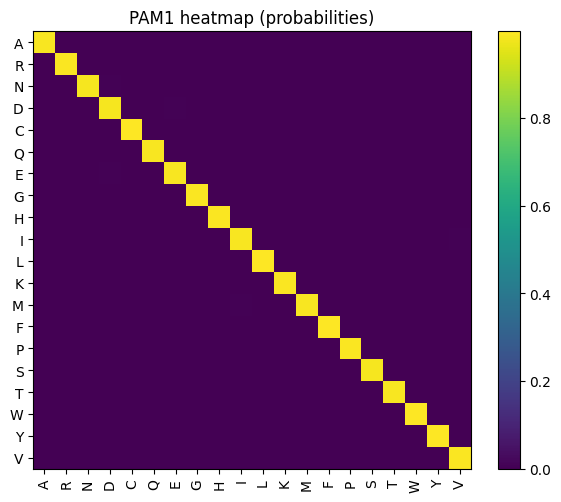

In [ ]:

heatmap(PAM1, "PAM1 heatmap (probabilities)")



## Build \( \mathrm{PAM}^n \) and visualize


PAM10


,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V
A,0.875914,0.001054,0.003996,0.005753,0.000959,0.002921,0.009201,0.019588,0.001071,0.002089,0.002935,0.001941,0.000971,0.000977,0.012085,0.025225,0.020081,0.000023,0.000964,0.011870
R,0.002156,0.916742,0.001284,0.000144,0.000960,0.008390,0.000247,0.001113,0.007515,0.001932,0.001076,0.034485,0.000997,0.001032,0.004796,0.010110,0.002158,0.000005,0.000033,0.001961
N,0.008897,0.001277,0.836885,0.036733,0.000022,0.003966,0.007272,0.011381,0.016136,0.002769,0.001952,0.022509,0.000095,0.001000,0.002102,0.029748,0.012096,0.000085,0.002768,0.001986
D,0.009598,0.000113,0.031460,0.869513,0.000009,0.005181,0.049710,0.010484,0.003066,0.001008,0.000116,0.005879,0.000033,0.000042,0.000211,0.001841,0.006589,0.003717,0.000062,0.000188
C,0.003017,0.000990,0.000117,0.000041,0.973332,0.000036,0.000041,0.001094,0.000965,0.001928,0.000048,0.000030,0.000017,0.000019,0.001038,0.010195,0.001133,0.000005,0.000011,0.002911
Q,0.007681,0.009311,0.003988,0.006242,0.000023,0.883410,0.031397,0.003051,0.018300,0.001057,0.005677,0.011237,0.001846,0.001903,0.007495,0.004017,0.002976,0.000014,0.000068,0.002009
E,0.015626,0.000161,0.006142,0.047053,0.000013,0.024202,0.874621,0.006919,0.001259,0.001880,0.001061,0.001266,0.000050,0.000050,0.002965,0.005717,0.002264,0.000091,0.000023,0.001991
G,0.019602,0.000067,0.005661,0.005759,0.000014,0.001043,0.003955,0.937281,0.000093,0.001037,0.001975,0.000116,0.000950,0.000038,0.002099,0.014857,0.002319,0.000017,0.000027,0.002963
H,0.002153,0.009385,0.018808,0.004095,0.000959,0.021037,0.002328,0.000245,0.915808,0.000108,0.003866,0.002368,0.000050,0.000053,0.002026,0.004928,0.001186,0.000011,0.003784,0.002847
I,0.006043,0.002834,0.002769,0.001035,0.000990,0.003694,0.001093,0.000246,0.000180,0.880090,0.020716,0.003794,0.004649,0.007458,0.001077,0.002166,0.010170,0.000007,0.001038,0.051658


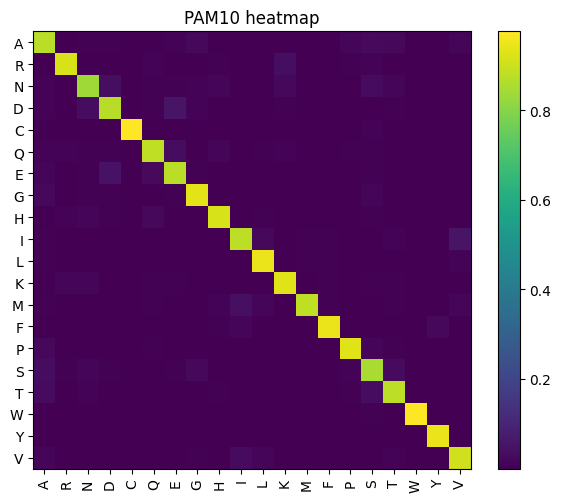

PAM50


,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V
A,0.533935,0.005891,0.018404,0.023834,0.004034,0.012840,0.032782,0.072893,0.006353,0.010992,0.013402,0.008850,0.004212,0.004457,0.044279,0.081385,0.067962,0.000496,0.004170,0.040711
R,0.012931,0.654256,0.009918,0.003431,0.004054,0.031181,0.005025,0.007460,0.028816,0.008405,0.006615,0.126851,0.004711,0.005557,0.020022,0.036045,0.012667,0.000134,0.000808,0.009106
N,0.039872,0.009719,0.427099,0.104540,0.000483,0.018417,0.035811,0.045338,0.051063,0.010215,0.009012,0.072595,0.001738,0.004831,0.011603,0.085567,0.044123,0.001554,0.009994,0.009649
D,0.039986,0.002680,0.089190,0.522065,0.000242,0.025925,0.149720,0.042868,0.015248,0.005032,0.002573,0.025818,0.000763,0.000977,0.004494,0.018680,0.025957,0.013775,0.001224,0.003834
C,0.014859,0.004654,0.002235,0.001029,0.873726,0.000838,0.001005,0.006942,0.004230,0.008272,0.001160,0.000789,0.000384,0.000434,0.005713,0.037394,0.007444,0.000108,0.000262,0.012801
Q,0.032178,0.034356,0.018814,0.031589,0.000516,0.548571,0.098988,0.015913,0.062476,0.005956,0.022589,0.042714,0.006640,0.007797,0.028516,0.019521,0.014301,0.000370,0.001435,0.009995
E,0.055388,0.003287,0.029166,0.141756,0.000306,0.075991,0.535036,0.031939,0.009661,0.007487,0.006224,0.010075,0.001004,0.001092,0.013818,0.023998,0.014375,0.001729,0.000608,0.009578
G,0.073194,0.001501,0.022145,0.024065,0.000340,0.005886,0.018347,0.730351,0.002084,0.005671,0.009383,0.002551,0.003863,0.000863,0.011700,0.054508,0.015574,0.000394,0.000631,0.013821
H,0.013026,0.035710,0.059155,0.020457,0.004024,0.071655,0.015708,0.005290,0.650393,0.002241,0.016661,0.016559,0.001054,0.001190,0.010303,0.022152,0.008571,0.000291,0.014831,0.011636
I,0.029091,0.011242,0.010322,0.005693,0.004650,0.013514,0.006705,0.005322,0.003559,0.542092,0.080009,0.015227,0.017027,0.027798,0.006591,0.012780,0.036757,0.000168,0.005658,0.168921


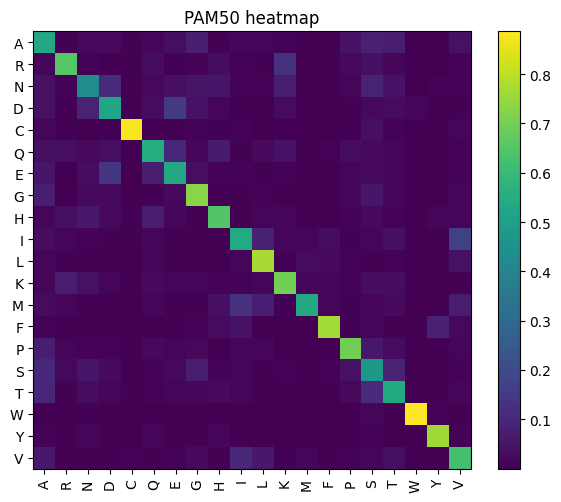

PAM100


,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V
A,0.316039,0.011828,0.030514,0.037774,0.006699,0.021682,0.045826,0.104029,0.013370,0.020103,0.024108,0.016463,0.007006,0.008065,0.061975,0.100078,0.086815,0.001532,0.007186,0.054088
R,0.027472,0.440065,0.021527,0.011161,0.006722,0.044543,0.014485,0.017623,0.042467,0.014486,0.014770,0.175230,0.008307,0.011130,0.032352,0.050994,0.025705,0.000511,0.002776,0.016865
N,0.065300,0.020758,0.206970,0.112018,0.001546,0.031739,0.058781,0.069749,0.061619,0.015465,0.016870,0.089478,0.004475,0.008912,0.022872,0.095041,0.060956,0.004016,0.014244,0.018368
D,0.063895,0.008635,0.095069,0.307558,0.000890,0.043984,0.167702,0.068147,0.027048,0.009632,0.008191,0.042098,0.002434,0.003197,0.013438,0.040412,0.040441,0.019954,0.003506,0.011130
C,0.027751,0.008469,0.006142,0.003609,0.763724,0.002806,0.003503,0.015651,0.007518,0.013903,0.004041,0.002893,0.001224,0.001464,0.011764,0.053783,0.016108,0.000365,0.000938,0.022033
Q,0.052310,0.048434,0.032746,0.054087,0.001642,0.318105,0.117195,0.031737,0.080085,0.012034,0.035242,0.062844,0.009378,0.012652,0.042065,0.035523,0.026700,0.001351,0.004339,0.019102
E,0.076953,0.009500,0.046831,0.158744,0.001059,0.089399,0.319821,0.055698,0.021195,0.012242,0.013441,0.023145,0.002877,0.003415,0.024699,0.040252,0.029320,0.004635,0.002176,0.017791
G,0.104867,0.004826,0.033559,0.038781,0.001181,0.012414,0.032302,0.546194,0.006594,0.011492,0.017670,0.008028,0.006208,0.002835,0.023571,0.077175,0.032770,0.001287,0.002097,0.024803
H,0.027987,0.051749,0.070589,0.036341,0.006622,0.091399,0.032804,0.016262,0.433074,0.006603,0.027961,0.035543,0.003122,0.003822,0.019813,0.037243,0.019425,0.001047,0.022145,0.019173
I,0.051087,0.017606,0.016047,0.011857,0.008375,0.019917,0.014267,0.016294,0.009921,0.316373,0.118137,0.023985,0.023697,0.039978,0.014482,0.025908,0.051613,0.000611,0.011380,0.204970


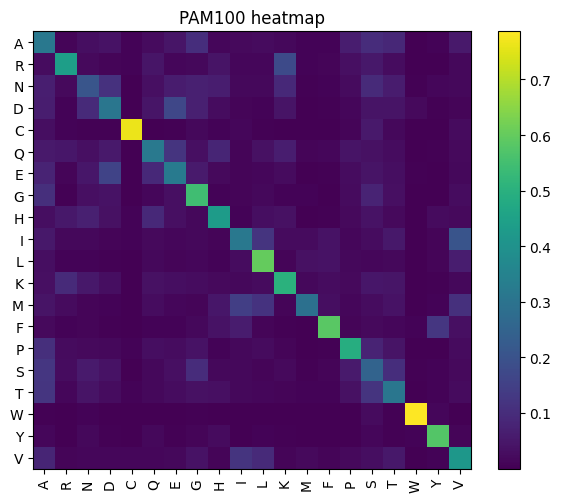

PAM250


,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V
A,0.129164,0.023427,0.040632,0.050310,0.010886,0.033507,0.053361,0.114284,0.027226,0.030698,0.044206,0.033326,0.010574,0.015488,0.065027,0.085581,0.075831,0.004902,0.012927,0.056387
R,0.059517,0.161922,0.039221,0.033813,0.010828,0.049887,0.037866,0.047365,0.049506,0.025056,0.036291,0.159285,0.012845,0.022215,0.046901,0.063434,0.048516,0.002626,0.010459,0.034013
N,0.087318,0.036062,0.062549,0.074467,0.005315,0.044831,0.067897,0.091377,0.050882,0.023704,0.035395,0.076589,0.009430,0.016624,0.042403,0.076817,0.063875,0.008865,0.017863,0.036135
D,0.087058,0.025172,0.062105,0.111469,0.003946,0.053487,0.106320,0.094293,0.039841,0.019663,0.027295,0.056923,0.007295,0.010940,0.036300,0.065990,0.055839,0.023768,0.010003,0.030385
C,0.051764,0.015928,0.016060,0.013949,0.511510,0.010589,0.013960,0.038983,0.014865,0.022545,0.016335,0.012295,0.004156,0.005795,0.025918,0.065678,0.033820,0.001573,0.004111,0.036986
Q,0.077688,0.051217,0.046760,0.067193,0.005603,0.095892,0.086908,0.065551,0.066362,0.023957,0.050615,0.074224,0.011575,0.020000,0.052121,0.059885,0.048919,0.005210,0.012736,0.037501
E,0.088697,0.024822,0.052511,0.100249,0.004263,0.064701,0.117353,0.086841,0.037799,0.021080,0.032021,0.046669,0.007610,0.011125,0.042164,0.062221,0.051670,0.010580,0.008413,0.033958
G,0.116063,0.016298,0.042909,0.054037,0.004723,0.027490,0.051569,0.263516,0.020706,0.023552,0.036597,0.025836,0.009592,0.010182,0.045413,0.085356,0.058733,0.004602,0.007789,0.043009
H,0.059945,0.055698,0.056087,0.053215,0.010439,0.073564,0.055760,0.048918,0.149511,0.018525,0.044674,0.064105,0.008384,0.012614,0.037712,0.055985,0.041744,0.004206,0.025747,0.033062
I,0.077131,0.025802,0.026329,0.026973,0.014487,0.028449,0.030758,0.048092,0.024527,0.102200,0.132474,0.035635,0.023644,0.045144,0.032986,0.048977,0.058665,0.002752,0.022696,0.144269


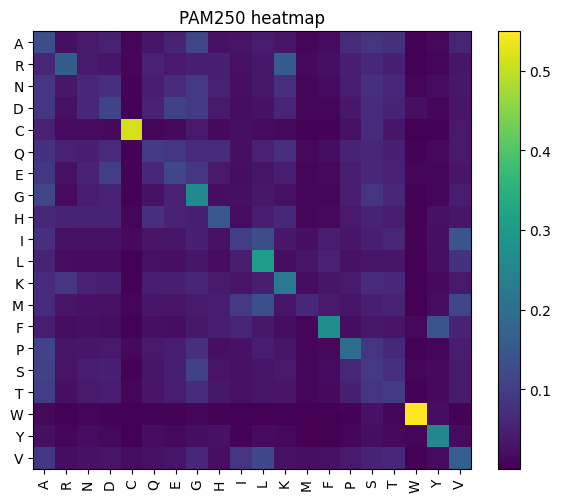

In [ ]:

for n in [10, 50, 100, 250]:
    Pn = pam_power(PAM1, n)
    show_df(Pn, f"PAM{n}", round_to=6)
    heatmap(Pn, f"PAM{n} heatmap")



## Mean diagonal probability vs. \(n\)


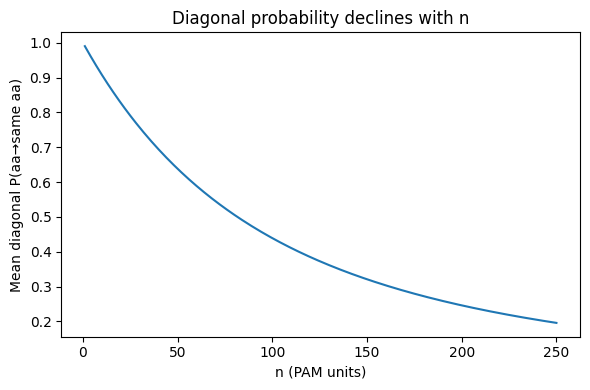

In [ ]:

ns = np.arange(1, 251)
diag_means = []
for n in ns:
    Pn = pam_power(PAM1, n)
    diag_means.append(np.mean(np.diag(Pn)))

plt.figure(figsize=(6,4))
plt.plot(ns, diag_means)
plt.xlabel("n (PAM units)")
plt.ylabel("Mean diagonal P(aa→same aa)")
plt.title("Diagonal probability declines with n")
plt.tight_layout()
plt.show()



## Optional: Estimate a rate matrix \(Q\) and reconstruct PAMⁿ


In [ ]:

Q_est = logm(PAM1).real
show_df(Q_est, "Estimated instantaneous rate matrix Q (approx. log(PAM1))", round_to=6)
PAM10_from_Q = expm(Q_est * 10).real
show_df(PAM10_from_Q, "PAM10 reconstructed from Q_est", round_to=6)
PAM10_direct = pam_power(PAM1, 10)
diff = np.abs(PAM10_from_Q - PAM10_direct)
print("Max abs difference between reconstructed and direct PAM10:", float(diff.max()))


Estimated instantaneous rate matrix Q (approx. log(PAM1))


,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V
A,-0.013404,0.000099,0.000400,0.000603,0.000100,0.000301,0.001009,0.002116,0.000099,0.000199,0.000301,0.000201,0.000100,0.000100,0.001311,0.002833,0.002223,-0.000000,0.000100,0.001313
R,0.000198,-0.008743,0.000096,-0.000002,0.000100,0.000907,-0.000003,0.000099,0.000806,0.000201,0.000099,0.003729,0.000100,0.000100,0.000502,0.001111,0.000198,-0.000000,-0.000000,0.000200
N,0.000901,0.000097,-0.017977,0.004264,-0.000000,0.000400,0.000696,0.001207,0.001822,0.000303,0.000201,0.002530,-0.000001,0.000100,0.000199,0.003452,0.001310,-0.000001,0.000303,0.000200
D,0.001005,-0.000001,0.003655,-0.014224,-0.000000,0.000497,0.005675,0.001106,0.000299,0.000100,-0.000001,0.000601,-0.000000,-0.000000,-0.000002,0.000089,0.000705,0.000403,-0.000001,-0.000002
C,0.000300,0.000100,-0.000001,-0.000000,-0.002704,-0.000000,-0.000000,0.000099,0.000100,0.000201,-0.000001,-0.000000,-0.000000,-0.000000,0.000100,0.001109,0.000098,-0.000000,-0.000000,0.000301
Q,0.000804,0.001008,0.000400,0.000597,-0.000000,-0.012486,0.003543,0.000299,0.002020,0.000099,0.000604,0.001209,0.000202,0.000201,0.000806,0.000400,0.000300,-0.000000,-0.000001,0.000200
E,0.001716,-0.000002,0.000598,0.005371,-0.000000,0.002733,-0.013614,0.000701,0.000097,0.000201,0.000099,0.000097,-0.000001,-0.000001,0.000300,0.000603,0.000197,-0.000001,-0.000000,0.000200
G,0.002116,-0.000001,0.000604,0.000603,-0.000000,0.000099,0.000400,-0.006526,-0.000001,0.000100,0.000200,-0.000001,0.000101,-0.000000,0.000199,0.001613,0.000196,-0.000000,-0.000000,0.000300
H,0.000198,0.001007,0.002126,0.000399,0.000100,0.002323,0.000196,-0.000003,-0.008844,-0.000001,0.000402,0.000195,-0.000001,-0.000001,0.000200,0.000501,0.000098,-0.000000,0.000402,0.000302
I,0.000599,0.000302,0.000303,0.000100,0.000100,0.000404,0.000099,-0.000003,-0.000002,-0.012895,0.002215,0.000402,0.000504,0.000806,0.000099,0.000198,0.001110,-0.000000,0.000100,0.005763


PAM10 reconstructed from Q_est


,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V
A,0.875914,0.001054,0.003996,0.005753,0.000959,0.002921,0.009201,0.019588,0.001071,0.002089,0.002935,0.001941,0.000971,0.000977,0.012085,0.025225,0.020081,0.000023,0.000964,0.011870
R,0.002156,0.916742,0.001284,0.000144,0.000960,0.008390,0.000247,0.001113,0.007515,0.001932,0.001076,0.034485,0.000997,0.001032,0.004796,0.010110,0.002158,0.000005,0.000033,0.001961
N,0.008897,0.001277,0.836885,0.036733,0.000022,0.003966,0.007272,0.011381,0.016136,0.002769,0.001952,0.022509,0.000095,0.001000,0.002102,0.029748,0.012096,0.000085,0.002768,0.001986
D,0.009598,0.000113,0.031460,0.869513,0.000009,0.005181,0.049710,0.010484,0.003066,0.001008,0.000116,0.005879,0.000033,0.000042,0.000211,0.001841,0.006589,0.003717,0.000062,0.000188
C,0.003017,0.000990,0.000117,0.000041,0.973332,0.000036,0.000041,0.001094,0.000965,0.001928,0.000048,0.000030,0.000017,0.000019,0.001038,0.010195,0.001133,0.000005,0.000011,0.002911
Q,0.007681,0.009311,0.003988,0.006242,0.000023,0.883410,0.031397,0.003051,0.018300,0.001057,0.005677,0.011237,0.001846,0.001903,0.007495,0.004017,0.002976,0.000014,0.000068,0.002009
E,0.015626,0.000161,0.006142,0.047053,0.000013,0.024202,0.874621,0.006919,0.001259,0.001880,0.001061,0.001266,0.000050,0.000050,0.002965,0.005717,0.002264,0.000091,0.000023,0.001991
G,0.019602,0.000067,0.005661,0.005759,0.000014,0.001043,0.003955,0.937281,0.000093,0.001037,0.001975,0.000116,0.000950,0.000038,0.002099,0.014857,0.002319,0.000017,0.000027,0.002963
H,0.002153,0.009385,0.018808,0.004095,0.000959,0.021037,0.002328,0.000245,0.915808,0.000108,0.003866,0.002368,0.000050,0.000053,0.002026,0.004928,0.001186,0.000011,0.003784,0.002847
I,0.006043,0.002834,0.002769,0.001035,0.000990,0.003694,0.001093,0.000246,0.000180,0.880090,0.020716,0.003794,0.004649,0.007458,0.001077,0.002166,0.010170,0.000007,0.001038,0.051658


Max abs difference between reconstructed and direct PAM10: 2.3314683517128287e-14
